<a href="https://colab.research.google.com/github/BermanOmri/DeepLearningCourse/blob/main/Hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Excercise Setup:

# Import packages:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
# Change to excercises direcotry:
import os
os.chdir('/content/drive/My Drive/DLCourse/Hw1')


In [ ]:
## Load Training and Test Sets:

# Apply normalization over imported images:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Import Train and Test sets:
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Implement and instantiate LeNet5 (Based on implementaition seen in https://github.com/ChawDoe/LeNet5-MNIST-PyTorch, with several modifications):
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.dropout = nn.Dropout(p = 0)

    def forward(self, x):
        # x = x.view(1, -1, 28,28)
        x = self.dropout(F.max_pool2d(F.relu(self.conv1(x)), 2)) # Conv -> Relu -> Max Pooling
        x = self.dropout(F.max_pool2d(F.relu(self.conv2(x)), 2)) # Conv -> Relu -> Max Pooling
        x = x.view(x.shape[0], -1) # Flattening
        x = self.dropout(F.relu(self.fc1(x))) # MLP -> Relu
        x = self.dropout(F.relu(self.fc2(x))) # MLP -> Relu
        x = self.dropout(F.relu(self.fc3(x))) # MLP -> Relu

        return F.log_softmax(x) # Return the log-Likelihood distribution

    def classify(self, x):
        out = self.forward(x)        
        probs = torch.exp(out)
        _, preds = probs.topk(1, dim=1)
        return preds


In [ ]:
## Success Counter:

import numpy as np

def getSuccesses(likelihood, labels):
  _, mlClass = likelihood.topk(1, dim=1)
  equals = mlClass == labels.view(*mlClass.shape)
  return mlClass.cpu().numpy(), np.count_nonzero(equals.cpu().numpy())


In [ ]:
## Train the Network:

lenet5 = LeNet5()  # Instantiation

# Setup HyperParameters, Loss Criteria, Optimizer:
learningRate = 0.1
nEpochs = 20
losCriterion = nn.NLLLoss()
optimizer = optim.SGD(lenet5.parameters(), lr=learningRate)

trainLosses, testLosses, trainAccuracy, testAccuracy = [], [], [], []
lenet5.to('cuda')
for epoch in range(nEpochs):
    trainLoss = 0
    testLoss = 0
    trainSuccesses = 0
    testSuccesses = 0

    # Training:
    for images, labels in trainLoader: 
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad() # Set accumulated gradients to zero
        logLikelihood = lenet5.forward(images) # Forward-Pass
        # print(torch.exp(logLikelihood))
        # break
        batchLoss = losCriterion(logLikelihood, labels) # Apply Forward-Pass
        batchLoss.backward() # Back-Propogation
        optimizer.step() # Gradient Descent        

        trainLoss += batchLoss.item() # Calculate accumulative loss
        _, success = getSuccesses(torch.exp(logLikelihood), labels)
        trainSuccesses += success # Calculate accumulative Miss-Classifications
    # break
    # Validation:
    with torch.no_grad(): # Turn off gradient calculations for efficiency
        lenet5.eval()
        for images, labels in testLoader:
            images, labels = images.to('cuda'), labels.to('cuda')

            logLikelihood = lenet5.forward(images) # Forward-Pass

            testLoss += losCriterion(logLikelihood, labels).item()      
            _, success = getSuccesses(torch.exp(logLikelihood), labels)          
            testSuccesses += success # Calculate accumulative Miss-Classifications
    
    lenet5.train()
    
    trainLosses.append(trainLoss/len(trainLoader))
    testLosses.append(testLoss/len(testLoader))        
    trainAccuracy.append(trainSuccesses/len(trainset) * 100)
    testAccuracy.append(testSuccesses/len(testset) * 100)
    print(f"Epoch #{epoch + 1} is completed")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch #1 is completed
Epoch #2 is completed
Epoch #3 is completed
Epoch #4 is completed
Epoch #5 is completed
Epoch #6 is completed
Epoch #7 is completed
Epoch #8 is completed
Epoch #9 is completed
Epoch #10 is completed
Epoch #11 is completed
Epoch #12 is completed
Epoch #13 is completed
Epoch #14 is completed
Epoch #15 is completed
Epoch #16 is completed
Epoch #17 is completed
Epoch #18 is completed
Epoch #19 is completed
Epoch #20 is completed


[70.42166666666667, 84.54333333333334, 87.145, 88.17, 89.045, 89.59666666666666, 90.05166666666666, 90.53166666666667, 91.00666666666667, 91.25333333333333, 91.595, 91.82333333333334, 92.13333333333334, 92.32333333333334, 92.54833333333333, 92.87833333333333, 93.06, 93.25666666666666, 93.54333333333334, 93.71666666666667]
[79.07, 83.14, 86.42, 86.85000000000001, 87.08, 87.72999999999999, 88.21, 88.14, 89.13, 89.03999999999999, 89.12, 89.22, 88.92, 89.03, 88.31, 89.62, 86.97, 89.12, 89.71000000000001, 89.22]


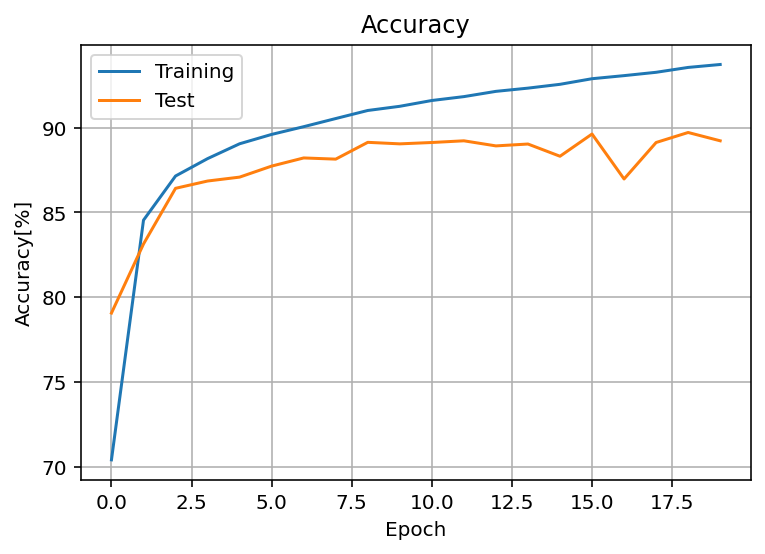

In [ ]:
print(trainAccuracy)
print(testAccuracy)
plt.plot(trainAccuracy, label='Training')
plt.plot(testAccuracy, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy[%]')
plt.grid()
plt.legend()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(-0.5, 27.5, 27.5, -0.5)

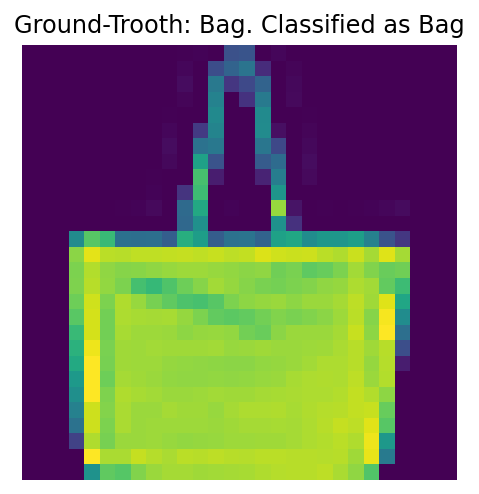

In [ ]:
## Inference validation:
images, labels = next(iter(testLoader))
images, labels = images.to('cuda'), labels.to('cuda')
with torch.no_grad():
  logLikelihood = lenet5.forward(images)
testset.classes
mlClasses, testSuccesses = getSuccesses(torch.exp(logLikelihood), labels)


(-0.5, 27.5, 27.5, -0.5)

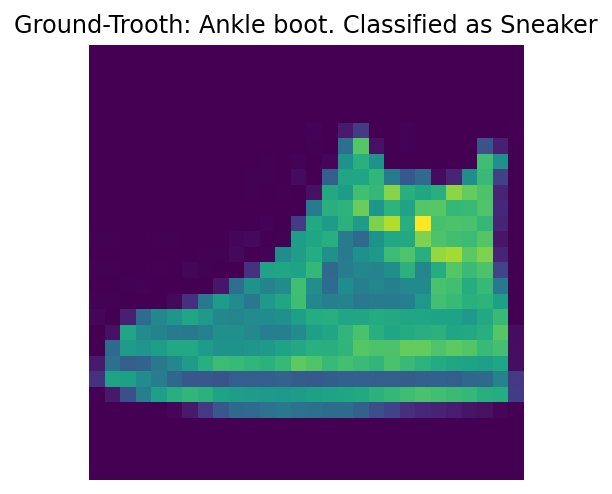

In [ ]:
imgIdx = 13
plt.imshow(images[imgIdx].cpu().view(28, 28))

ax = plt.title(f"Ground-Trooth: {testset.classes[labels[imgIdx]]}. Classified as {testset.classes[mlClasses[imgIdx][0]]}")
plt.axis('off')

In [ ]:
testset.classes


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']